<a href="https://colab.research.google.com/github/Taghreed-Alzahrani/Basket-Analysis/blob/main/Basket_Analysis_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Required Libraries**

In [5]:

!pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Install Required Libraries**

In [7]:
# Load the dataset with proper encoding
df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Check the first few rows
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Exploratory Data Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


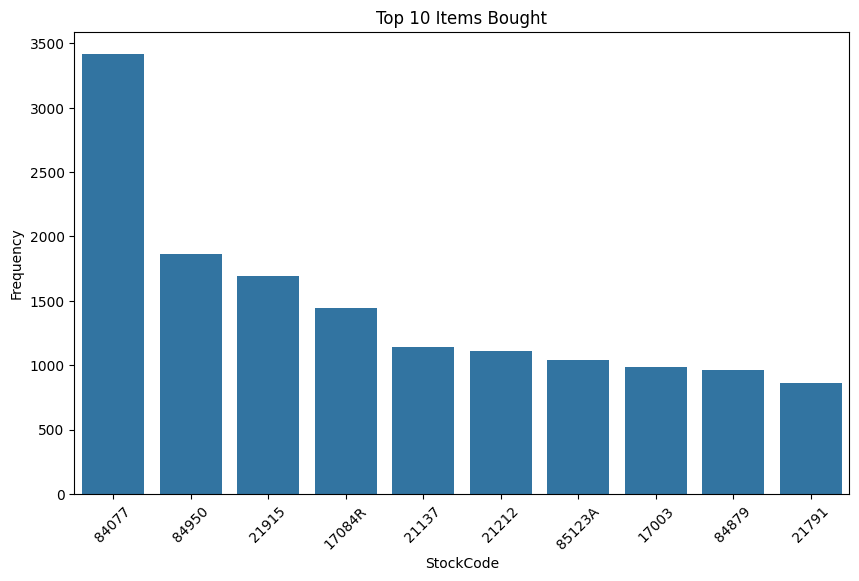

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#حساب تردد العناصر
item_frequency = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False)

top_10_items = item_frequency.head(10)

# رسم تردد العناصر
plt.figure(figsize=(10, 6))
sns.barplot(x=item_frequency.head(10).index, y=item_frequency.head(10).values)
plt.title('Top 10 Items Bought')
plt.xlabel('StockCode')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# **Data Preprocessing**

In [10]:
# تحويل InvoiceNo و StockCode إلى نوع سلسلة نصية
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)

# حذف أي صفوف تحتوي على كميات سالبة (قد تشير إلى عودة المنتجات)
df = df[df['Quantity'] > 0]

#نحدفو لان نحتاج نحلل سلوك شراء العميل(CustomerID)ادا لم يوجد
df = df.dropna(subset=['CustomerID'])

# إنشاء جدول  حيث يمثل كل صف رقم الفاتورة وكل عمود يمثل رمز المخزون
#fill_value=0: يملأ القيم الفارغة بالصفر، مما يعني أن المنتج لم يُشترَ في تلك المعاملة
basket = df.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack(fill_value=0)

# تحويل الكميات إلى1و0  : 1  للمنتجات التي تم شراؤها، و 0 للمنتجات التي لم تُشترَ
basket = (basket > 0).astype(int)

# عرض أول few صفوف من السلة المشفرة ثنائياً
basket.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


StockCode,10002,10120,10123C,10124G,10125,10133,10135,11001,15034,15036,...,90204,90210B,90214J,90214M,90214S,90214V,BANK CHARGES,C2,M,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Apriori Algorithm to Find Frequent Itemsets**

In [11]:
from mlxtend.frequent_patterns import apriori

# Subset the first 20000 rows for analysis
basket_subset = basket.head(20000)

# استخدمنا خوارزمية Apriori عشان تحدد العناصر الشائعةبحد ادنى لازم تكون ظاهرة(5%)
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)


frequent_itemsets.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.054585,(21034)
1,0.052402,(21212)
2,0.065502,(21479)
3,0.054585,(21485)
4,0.106987,(22086)
5,0.065502,(22111)
6,0.056769,(22112)
7,0.063319,(22114)
8,0.052402,(22197)
9,0.054585,(22411)


# **Generate Association Rules**

In [12]:
from mlxtend.frequent_patterns import association_rules

# Generate the association rules from the frequent itemsets
# We will use the 'lift' metric
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)


# Display the first few rules
rules.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(22910),(22086),0.089520,0.106987,0.052402,0.585366,5.471379,0.042824,2.153737,0.897582
1,(22086),(22910),0.106987,0.089520,0.052402,0.489796,5.471379,0.042824,1.784541,0.915139
2,(22633),(22632),0.135371,0.139738,0.080786,0.596774,4.270665,0.061870,2.133450,0.885749
3,(22632),(22633),0.139738,0.135371,0.080786,0.578125,4.270665,0.061870,2.049491,0.890246
4,(22865),(22632),0.111354,0.139738,0.058952,0.529412,3.788603,0.043392,1.828057,0.828283
5,(22632),(22865),0.139738,0.111354,0.058952,0.421875,3.788603,0.043392,1.537118,0.855612
6,(22632),(22866),0.139738,0.120087,0.061135,0.437500,3.643182,0.044355,1.564289,0.843365
7,(22866),(22632),0.120087,0.139738,0.061135,0.509091,3.643182,0.044355,1.752386,0.824530
8,(22633),(22866),0.135371,0.120087,0.054585,0.403226,3.357771,0.038329,1.474448,0.812121
9,(22866),(22633),0.120087,0.135371,0.054585,0.454545,3.357771,0.038329,1.585153,0.798015


# **Filter and Analyze Rules**

In [15]:
from google.colab import data_table
# تصفية القواعد بناءً على شروط معينة:
# يتم الاحتفاظ بالقواعد التي لديها ثقة (confidence) أكبر من 0.6
# ورفع (lift) أكبر من 1.2
filtered_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.2)]
#  لعرض البيانات
data_table.DataTable(filtered_rules, include_index=False, num_rows_per_page=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,(22865),(22866),0.111354,0.120087,0.072052,0.647059,5.388235,0.058680,2.493086,0.916462
14,(22867),(22866),0.093886,0.120087,0.056769,0.604651,5.035095,0.045494,2.225661,0.884430
16,(84029G),(84029E),0.078603,0.089520,0.058952,0.750000,8.378049,0.051915,3.641921,0.955766
17,(84029E),(84029G),0.089520,0.078603,0.058952,0.658537,8.378049,0.051915,2.698378,0.967226
20,(84029G),(85123A),0.078603,0.122271,0.050218,0.638889,5.225198,0.040608,2.430635,0.877601


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


from matplotlib import pyplot as plt
_df_0['antecedent support'].plot(kind='hist', bins=20, title='antecedent support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['consequent support'].plot(kind='hist', bins=20, title='consequent support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('antecedents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('consequents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='antecedent support', y='consequent support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='consequent support', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='support', y='confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='confidence', y='lift', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['antecedent support'].plot(kind='line', figsize=(8, 4), title='antecedent support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['consequent support'].plot(kind='line', figsize=(8, 4), title='consequent support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['confidence'].plot(kind='line', figsize=(8, 4), title='confidence')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['consequents'].value_counts()
    for x_label, grp in _df_14.groupby('antecedents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('antecedents')
_ = plt.ylabel('consequents')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='antecedent support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['consequents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='antecedent support', y='consequents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='consequent support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['consequents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='consequent support', y='consequents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# **Save the Filtered Rules**

In [14]:
# Save the filtered rules to a CSV file
filtered_rules.to_csv('/content/filtered_association_rules.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
